This notebook:
1. Get's plant metadata from ERCOT and EIA
2. Tries to match up that metadata to positively ID plants
3. For plants with a metadata match, it pulls timeseries data from ERCOT using the gridstatus.io API
4. Writes specs (metadata) and timeseries power data for each plant into .csv files to be processed in [Process_Specs_Updated.ipynb](Process_Specs_Updated.ipynb)

_Code for pulling from gridstatus.io and matching with EIA was based on code by Drumil Joshi, Southern Power Company._

Suggested environment setup using miniforge:

```
conda create -n PVPMC_2025 python=3.12 -y
conda activate PVPMC_2025
pip install gridstatusio openpyxl python-Levenshtein fuzzywuzzy thefuzz
pip install pandas matplotlib ipykernel jupyter
pip install git+https://github.com/pvlib/pvlib-python@v0.12.1-alpha.1

```

In [34]:
## API key credentials are stored in a separate text file
with open('gridstatus_api_key.txt') as f: # full path and filename of text file with api key on first line
    api_key = f.readline().rstrip()  # rstrip removes trailing line breaks and spaces

In [ ]:
import pandas as pd
import os
# from fuzzywuzzy import process
from thefuzz import process # thefuzz seems better and faster than fuzzywuzzy
from gridstatusio import GridStatusClient
import urllib.request 
import zipfile
import re

Get ERCOT Capacity Demand Reserves (CDR) report file for mapping ERCOT unit names with EIA plant names:

In [36]:
ercot_cdr_url = 'https://www.ercot.com/files/docs/2024/05/24/CapacityDemandandReservesReport_May2024_Revised.xlsx'
cdr_filename = 'input_specs/CapacityDemandandReservesReport_May2024_Revised.xlsx'
urllib.request.urlretrieve(ercot_cdr_url, cdr_filename)

('input_specs/CapacityDemandandReservesReport_May2024_Revised.xlsx',
 <http.client.HTTPMessage at 0x185caa33c50>)

Create a dataframe of just the solar plants:

In [37]:
CDR_FILE = cdr_filename
CDR_SHEET = "SummerCapacities"
cdr_df = pd.read_excel(CDR_FILE, sheet_name=CDR_SHEET, header=1)
cdr_df = cdr_df[cdr_df['FUEL'] == 'SOLAR']
cdr_df.head()

,Unnamed: 0,UNIT NAME,INR,UNIT CODE,COUNTY,FUEL,ZONE,IN SERVICE,INSTALLED CAPACITY \nRATING \n(MW),2025,2026,2027,2028,2029,2030,2031,2032,2033,2034
876,879.0,ACACIA SOLAR,NaN,ACACIA_UNIT_1,PRESIDIO,SOLAR,WEST,2012.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0
877,880.0,ALEXIS SOLAR,NaN,DG_ALEXIS_ALEXIS,BROOKS,SOLAR,SOUTH,2019.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0
878,881.0,ANDROMEDA SOLAR U1,NaN,ANDMDSLR_UNIT1,SCURRY,SOLAR,WEST,2024.0,158.8,158.0,158.0,158.0,158.0,158.0,158.0,158.0,158.0,158.0,158.0
879,882.0,ANDROMEDA SOLAR U2,NaN,ANDMDSLR_UNIT2,SCURRY,SOLAR,WEST,2024.0,162.4,162.0,162.0,162.0,162.0,162.0,162.0,162.0,162.0,162.0,162.0
880,883.0,ANSON SOLAR U1,NaN,ANSON1_UNIT1,JONES,SOLAR,WEST,2022.0,100.8,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0


Get EIA plant data. It's in a zip file:

In [38]:
eia_860_url = 'https://www.eia.gov/electricity/data/eia860/xls/eia8602023.zip'
filehandle, _ = urllib.request.urlretrieve(eia_860_url)
zip_file_object = zipfile.ZipFile(filehandle, 'r')

Look at filenames in the zip file. We want `2__Plant*.xlsx` and `3_3_Solar*.xlsx`:

In [39]:
zip_file_object.namelist()

['1___Utility_Y2023.xlsx',
 '2___Plant_Y2023.xlsx',
 '3_1_Generator_Y2023.xlsx',
 '3_2_Wind_Y2023.xlsx',
 '3_3_Solar_Y2023.xlsx',
 '3_4_Energy_Storage_Y2023.xlsx',
 '3_5_Multifuel_Y2023.xlsx',
 '4___Owner_Y2023.xlsx',
 '6_1_EnviroAssoc_Y2023.xlsx',
 '6_2_EnviroEquip_Y2023.xlsx',
 'EIA-860 Form.xlsx',
 'EIA-860 instructions.pdf',
 'LayoutY2023.xlsx']

In [42]:
EIA_PLANT_FILE = zip_file_object.extract(
    zip_file_object.namelist()[1], # second file in the list above
    path='input_specs/') 
EIA_SOLAR_FILE = zip_file_object.extract(
    zip_file_object.namelist()[4], # 5th file in the list above
    path='input_specs/')

In [43]:
eia_plant_df = pd.read_excel(EIA_PLANT_FILE, sheet_name="Plant", header=1)
eia_solar_df = pd.read_excel(EIA_SOLAR_FILE, sheet_name="Operable", header=1)

Merge EIA dataframes on Plant Code to add latitude and longitude to the Solar data:

In [44]:
eia_df = eia_solar_df.merge(eia_plant_df[['Plant Code', 'Latitude', 'Longitude']], on='Plant Code', how='inner')
eia_df.head()

,Utility ID,Utility Name,Plant Code,Plant Name,State,County,Generator ID,Status,Technology,Prime Mover,...,Thin-Film (A-Si)?,Thin-Film (CIGS)?,Thin-Film (Other)?,Other Materials?,Net Metering Agreement?,Net Metering DC Capacity (MW),Virtual Net Metering Agreement?,Virtual Net Metering DC Capacity (MW),Latitude,Longitude
0,16572,Salt River Project,141,Agua Fria,AZ,Maricopa,PV-3,OP,Solar Photovoltaic,PV,...,NaN,NaN,NaN,NaN,N,,N,,33.5561,-112.2153
1,18454,Tampa Electric Co,645,Big Bend,FL,Hillsborough,1,OP,Solar Photovoltaic,PV,...,NaN,NaN,NaN,NaN,N,,N,,27.7944,-82.4036
2,7095,City of Geneseo - (IL),944,Geneseo,IL,Henry,12,OP,Solar Photovoltaic,PV,...,NaN,NaN,NaN,NaN,N,,N,,41.451494,-90.148547
3,16179,Rochelle Municipal Utilities,960,North Ninth Street,IL,Ogle,SOL1,OP,Solar Photovoltaic,PV,...,NaN,NaN,NaN,NaN,Y,0.3,N,,41.9093,-89.0498
4,6235,Fayetteville Public Works Commission,1016,Butler-Warner Generation Plant,NC,Cumberland,10,OP,Solar Photovoltaic,PV,...,NaN,NaN,NaN,NaN,N,,N,,35.0986,-78.8294


Filter EIA to only Texas

In [45]:
eia_df = eia_df[eia_df['State'] == 'TX'].copy()

Make a column in EIA df that is plant name and county:

In [46]:
eia_df['plant_name_county'] = eia_df[['Plant Name','County']].agg(' '.join,axis=1)

Function to merge CDR and EIA data. It combines plant names and counties into a single string. It also removes anything in parentheses in the CDR plant name (this seemed to cause problems, but maybe not always...).

In [47]:
def merge_cdr_with_eia_info(selected_unit_names, cdr_df, eia_df):
    choices = eia_df['plant_name_county'].unique()
    cdr_column_nameplate = "INSTALLED CAPACITY \nRATING \n(MW)"
    eia_solar_columns = eia_df.columns.tolist()
    output_data = []
    i=0
    for unit_name in selected_unit_names:
        cdr_row = cdr_df[cdr_df["UNIT NAME"] == unit_name]
        if cdr_row.empty:
            print(f"CDR unit '{unit_name}' not found.")
            continue
        cdr_row = cdr_row.iloc[0]
        unit_county = cdr_df[cdr_df["UNIT NAME"] == unit_name].iloc[0]['COUNTY']
        cdr_unit_name_county = unit_name + ' ' + unit_county

        # remove anything in parentheses or brackets
        cdr_unit_name_county = re.sub("[\(\[].*?[\)\]]", "", cdr_unit_name_county)
        # remove multiple spaces
        cdr_unit_name_county = re.sub(' +', ' ', cdr_unit_name_county)

        # eia_match_name, score = process.extractOne(unit_name_test, choices)
        eia_match_name_county, score = process.extractOne(cdr_unit_name_county, choices)
        if score < 87:
            print(f"No strong EIA match for '{cdr_unit_name_county}' (Best guess: {eia_match_name_county}, Score: {score})")
            eia_match_row = None
        else:
            eia_match_row = eia_df[eia_df['plant_name_county'] == eia_match_name_county].iloc[0]

        output_data.append({
            "cdr file unit name": unit_name,
            "cdr unit code": cdr_row['UNIT CODE'],
            "cdr file nameplate ac mw": cdr_row[cdr_column_nameplate],
            "cdr file county": cdr_row['COUNTY'],
            "eia plant name": eia_match_row["Plant Name"] if score >= 87 else None,
            "eia county": eia_match_row["County"] if score >= 87 else None,
            "eia nameplate ac": eia_match_row["Nameplate Capacity (MW)"] if eia_match_row is not None else None,
            "eia lat": eia_match_row["Latitude"] if eia_match_row is not None else None,
            "eia lon": eia_match_row["Longitude"] if eia_match_row is not None else None,
        })

        # Add full EIA columns
        if eia_match_row is not None:
            for col in eia_solar_columns:
                output_data[i][f"eia solar {col}"] = eia_match_row.loc[col]
        else:
            print(f"⚠ No EIA Solar row matching CDR: {cdr_unit_name_county}")
        i += 1


    return pd.DataFrame(output_data)


<>:17: SyntaxWarning: invalid escape sequence '\('
<>:17: SyntaxWarning: invalid escape sequence '\('
C:\Users\willh\AppData\Local\Temp\ipykernel_65960\2495095591.py:17: SyntaxWarning: invalid escape sequence '\('
  cdr_unit_name_county = re.sub("[\(\[].*?[\)\]]", "", cdr_unit_name_county)


Then run it on lists of plant names taken from the CDR file. Plants were filtered to be in service 2022 or sooner and greater than 30 MW, then the first ~10 plants from each region (alphabetical) with unique names were selected.

In [ ]:
# west
unit_list = [
'ANSON SOLAR U1',
'ARAGORN SOLAR',
'AZURE SKY SOLAR U1',
'BHE SOLAR PEARL PROJECT (SIRIUS 2)',
'BLUEBELL SOLAR II 1 (CAPRICORN RIDGE 4)',
# 'BNB LAMESA SOLAR (PHASE I)', # skip this one
'CASTLE GAP SOLAR',
'EUNICE SOLAR U1',
'FOWLER RANCH',
# 'FS EAST PECOS SOLAR', # skip this one too
'GALLOWAY 1 SOLAR',
'GREASEWOOD SOLAR 1',
'HOLSTEIN SOLAR 1',
'JUNO SOLAR PHASE I',
'LAPETUS SOLAR',
]

merged_df_west = merge_cdr_with_eia_info(unit_list, cdr_df, eia_df)
merged_df_west


No strong EIA match for 'BHE SOLAR PEARL PROJECT PECOS' (Best guess: Barilla Solar Pecos, Score: 86)
⚠ No EIA Solar row matching CDR: BHE SOLAR PEARL PROJECT PECOS
No strong EIA match for 'EUNICE SOLAR U1 ANDREWS' (Best guess: Blue Wing Solar Energy Generation Bexar, Score: 86)
⚠ No EIA Solar row matching CDR: EUNICE SOLAR U1 ANDREWS
No strong EIA match for 'FOWLER RANCH CRANE' (Best guess: CED Crane Solar Crane, Score: 56)
⚠ No EIA Solar row matching CDR: FOWLER RANCH CRANE
No strong EIA match for 'JUNO SOLAR PHASE I BORDEN' (Best guess: Blue Wing Solar Energy Generation Bexar, Score: 86)
⚠ No EIA Solar row matching CDR: JUNO SOLAR PHASE I BORDEN


,cdr file unit name,cdr unit code,cdr file nameplate ac mw,cdr file county,eia plant name,eia county,eia nameplate ac,eia lat,eia lon,eia solar Utility ID,...,eia solar Thin-Film (CIGS)?,eia solar Thin-Film (Other)?,eia solar Other Materials?,eia solar Net Metering Agreement?,eia solar Net Metering DC Capacity (MW),eia solar Virtual Net Metering Agreement?,eia solar Virtual Net Metering DC Capacity (MW),eia solar Latitude,eia solar Longitude,eia solar plant_name_county
0,ANSON SOLAR U1,ANSON1_UNIT1,100.8,JONES,"ANSON Solar Center, LLC",Jones,200.0,32.811041,-99.917490,56201.0,...,NaN,NaN,NaN,N,,N,,32.811041,-99.917490,"ANSON Solar Center, LLC Jones"
1,ARAGORN SOLAR,ARAGORN_UNIT1,188.2,CULBERSON,Aragorn Solar Project,Culberson,187.2,31.719983,-104.442292,63101.0,...,NaN,NaN,NaN,N,,N,,31.719983,-104.442292,Aragorn Solar Project Culberson
2,AZURE SKY SOLAR U1,AZURE_SOLAR1,74.9,HASKELL,Azure Sky Solar,Haskell,225.0,33.021601,-99.614630,63571.0,...,NaN,NaN,NaN,N,,N,,33.021601,-99.614630,Azure Sky Solar Haskell
3,BHE SOLAR PEARL PROJECT (SIRIUS 2),SIRIUS_UNIT2,50.0,PECOS,None,None,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,BLUEBELL SOLAR II 1 (CAPRICORN RIDGE 4),CAPRIDG4_BB2_PV1,100.0,STERLING,Bluebell Solar II,Sterling,115.0,31.888000,-100.825000,63116.0,...,NaN,NaN,NaN,N,,N,,31.888000,-100.825000,Bluebell Solar II Sterling
5,CASTLE GAP SOLAR,CASL_GAP_UNIT1,180.0,UPTON,Castle Gap Solar Hybrid,Upton,180.0,31.255000,-102.272000,61123.0,...,NaN,NaN,NaN,N,,N,,31.255000,-102.272000,Castle Gap Solar Hybrid Upton
6,EUNICE SOLAR U1,EUNICE_PV1,189.6,ANDREWS,None,None,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,FOWLER RANCH,FWLR_SLR_UNIT1,152.5,CRANE,None,None,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,GALLOWAY 1 SOLAR,GALLOWAY_SOLAR1,250.0,CONCHO,Galloway 1 Solar Farm,Concho,250.0,31.435932,-99.796613,61523.0,...,NaN,NaN,NaN,N,,N,,31.435932,-99.796613,Galloway 1 Solar Farm Concho
9,GREASEWOOD SOLAR 1,GREASWOD_UNIT1,126.3,PECOS,Greasewood Solar,Pecos,255.0,31.030996,-102.488209,62705.0,...,NaN,NaN,NaN,N,,N,,31.030996,-102.488209,Greasewood Solar Pecos


In [49]:
# north
unit_list = [
    'CONIGLIO SOLAR',
'IMPACT SOLAR',
'KELLAM SOLAR',
'LILY SOLAR',
'NOBLE SOLAR U1',
'PHOENIX SOLAR',
'RIPPEY SOLAR',
'STRATEGIC SOLAR 1',
'VISION SOLAR 1',
'AGATE SOLAR',

]
merged_df_north = merge_cdr_with_eia_info(unit_list, cdr_df, eia_df)
merged_df_north

No strong EIA match for 'PHOENIX SOLAR FANNIN' (Best guess: Blue Wing Solar Energy Generation Bexar, Score: 86)
⚠ No EIA Solar row matching CDR: PHOENIX SOLAR FANNIN
No strong EIA match for 'RIPPEY SOLAR COOKE' (Best guess: Blue Wing Solar Energy Generation Bexar, Score: 86)
⚠ No EIA Solar row matching CDR: RIPPEY SOLAR COOKE
No strong EIA match for 'STRATEGIC SOLAR 1 ELLIS' (Best guess: Blue Wing Solar Energy Generation Bexar, Score: 86)
⚠ No EIA Solar row matching CDR: STRATEGIC SOLAR 1 ELLIS
No strong EIA match for 'VISION SOLAR 1 NAVARRO' (Best guess: Blue Wing Solar Energy Generation Bexar, Score: 86)
⚠ No EIA Solar row matching CDR: VISION SOLAR 1 NAVARRO
No strong EIA match for 'AGATE SOLAR ELLIS' (Best guess: Blue Wing Solar Energy Generation Bexar, Score: 86)
⚠ No EIA Solar row matching CDR: AGATE SOLAR ELLIS


,cdr file unit name,cdr unit code,cdr file nameplate ac mw,cdr file county,eia plant name,eia county,eia nameplate ac,eia lat,eia lon,eia solar Utility ID,...,eia solar Thin-Film (CIGS)?,eia solar Thin-Film (Other)?,eia solar Other Materials?,eia solar Net Metering Agreement?,eia solar Net Metering DC Capacity (MW),eia solar Virtual Net Metering Agreement?,eia solar Virtual Net Metering DC Capacity (MW),eia solar Latitude,eia solar Longitude,eia solar plant_name_county
0,CONIGLIO SOLAR,CONIGLIO_UNIT1,125.7,FANNIN,Coniglio Solar,Fannin,123.6,33.404486,-96.082472,62680.0,...,NaN,NaN,NaN,N,,N,,33.404486,-96.082472,Coniglio Solar Fannin
1,IMPACT SOLAR,IMPACT_UNIT1,198.5,LAMAR,Impact Solar 1,Lamar,198.5,33.467803,-95.370856,62842.0,...,NaN,NaN,NaN,N,,N,,33.467803,-95.370856,Impact Solar 1 Lamar
2,KELLAM SOLAR,KELAM_SL_UNIT1,59.8,VAN ZANDT,Kellam Solar,Van Zandt,59.0,32.474400,-95.715600,62682.0,...,NaN,NaN,NaN,N,,N,,32.474400,-95.715600,Kellam Solar Van Zandt
3,LILY SOLAR,LILY_SOLAR1,147.6,KAUFMAN,Lily Solar Hybrid,Kaufman,146.7,32.533273,-96.428985,63549.0,...,NaN,NaN,NaN,N,,N,,32.533273,-96.428985,Lily Solar Hybrid Kaufman
4,NOBLE SOLAR U1,NOBLESLR_SOLAR1,148.8,DENTON,Noble Solar,Denton,275.0,33.261505,-97.238057,64568.0,...,NaN,NaN,NaN,N,,N,,33.261505,-97.238057,Noble Solar Denton
5,PHOENIX SOLAR,PHOENIX_UNIT1,83.9,FANNIN,None,None,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,RIPPEY SOLAR,RIPPEY_UNIT1,59.8,COOKE,None,None,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,STRATEGIC SOLAR 1,STRATEGC_UNIT1,135.0,ELLIS,None,None,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,VISION SOLAR 1,VISION_UNIT1,129.2,NAVARRO,None,None,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,AGATE SOLAR,NaN,60.0,ELLIS,None,None,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [50]:
# south
unit_list = [
    'CORAZON SOLAR PHASE I',
'EAST BLACKLAND SOLAR (PFLUGERVILLE SOLAR)',
'ELARA SOLAR',
'OCI ALAMO 1 SOLAR',

]

merged_df_south = merge_cdr_with_eia_info(unit_list, cdr_df, eia_df)
merged_df_south

No strong EIA match for 'CORAZON SOLAR PHASE I WEBB' (Best guess: Blue Wing Solar Energy Generation Bexar, Score: 86)
⚠ No EIA Solar row matching CDR: CORAZON SOLAR PHASE I WEBB


,cdr file unit name,cdr unit code,cdr file nameplate ac mw,cdr file county,eia plant name,eia county,eia nameplate ac,eia lat,eia lon,eia solar Utility ID,...,eia solar Thin-Film (CIGS)?,eia solar Thin-Film (Other)?,eia solar Other Materials?,eia solar Net Metering Agreement?,eia solar Net Metering DC Capacity (MW),eia solar Virtual Net Metering Agreement?,eia solar Virtual Net Metering DC Capacity (MW),eia solar Latitude,eia solar Longitude,eia solar plant_name_county
0,CORAZON SOLAR PHASE I,CORAZON_UNIT1,202.6,WEBB,None,None,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,EAST BLACKLAND SOLAR (PFLUGERVILLE SOLAR),E_BLACK_UNIT_1,144.0,TRAVIS,East Blackland Solar Project 1,Travis,144.0,30.421400,-97.461400,65411.0,...,NaN,NaN,NaN,N,,N,,30.421400,-97.461400,East Blackland Solar Project 1 Travis
2,ELARA SOLAR,ELARA_SL_UNIT1,132.4,FRIO,Elara Solar,Frio,132.4,28.883196,-99.178605,62842.0,...,NaN,NaN,NaN,N,,N,,28.883196,-99.178605,Elara Solar Frio
3,OCI ALAMO 1 SOLAR,OCI_ALM1_UNIT1,39.2,BEXAR,OCI Alamo Solar I Hybrid,Bexar,40.7,29.271667,-98.444722,58489.0,...,NaN,NaN,NaN,N,,N,,29.271667,-98.444722,OCI Alamo Solar I Hybrid Bexar


In [51]:
# panhandle
unit_list = [
    'MISAE SOLAR U1',

]

merged_df_panhandle = merge_cdr_with_eia_info(unit_list, cdr_df, eia_df)
merged_df_panhandle

,cdr file unit name,cdr unit code,cdr file nameplate ac mw,cdr file county,eia plant name,eia county,eia nameplate ac,eia lat,eia lon,eia solar Utility ID,...,eia solar Thin-Film (CIGS)?,eia solar Thin-Film (Other)?,eia solar Other Materials?,eia solar Net Metering Agreement?,eia solar Net Metering DC Capacity (MW),eia solar Virtual Net Metering Agreement?,eia solar Virtual Net Metering DC Capacity (MW),eia solar Latitude,eia solar Longitude,eia solar plant_name_county
0,MISAE SOLAR U1,MISAE_UNIT1,121.4,CHILDRESS,Misae Solar,Childress,240.0,34.380532,-100.099625,63048,...,NaN,NaN,NaN,N,,N,,34.380532,-100.099625,Misae Solar Childress


In [52]:
# coastal
unit_list = [
    'NEBULA SOLAR (RAYOS DEL SOL) U1',
'WAGYU SOLAR',
'WESTORIA SOLAR U1',

]
merged_df_coastal = merge_cdr_with_eia_info(unit_list, cdr_df, eia_df)
merged_df_coastal

No strong EIA match for 'WESTORIA SOLAR U1 BRAZORIA' (Best guess: Blue Wing Solar Energy Generation Bexar, Score: 86)
⚠ No EIA Solar row matching CDR: WESTORIA SOLAR U1 BRAZORIA


,cdr file unit name,cdr unit code,cdr file nameplate ac mw,cdr file county,eia plant name,eia county,eia nameplate ac,eia lat,eia lon,eia solar Utility ID,...,eia solar Thin-Film (CIGS)?,eia solar Thin-Film (Other)?,eia solar Other Materials?,eia solar Net Metering Agreement?,eia solar Net Metering DC Capacity (MW),eia solar Virtual Net Metering Agreement?,eia solar Virtual Net Metering DC Capacity (MW),eia solar Latitude,eia solar Longitude,eia solar plant_name_county
0,NEBULA SOLAR (RAYOS DEL SOL) U1,NEBULA_UNIT1,137.5,CAMERON,Nebula Solar,Cameron,135.0,26.090103,-97.798453,64917.0,...,NaN,NaN,NaN,Y,181.5,N,,26.090103,-97.798453,Nebula Solar Cameron
1,WAGYU SOLAR,WGU_UNIT1,120.0,BRAZORIA,Wagyu,Brazoria,120.0,29.242304,-95.658144,62161.0,...,NaN,NaN,NaN,N,,N,,29.242304,-95.658144,Wagyu Brazoria
2,WESTORIA SOLAR U1,WES_UNIT1,101.6,BRAZORIA,None,None,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Here's a function for getting timeseries data for the plants from gridstatus.io. 

In [53]:
def export_specs_and_timeseries(
    merged_df,
    start_datetime,
    end_datetime,
    api_key,
    output_spec_folder=".",
    output_timeseries_folder='.',
    cert_path=None,
):
    dataset_name="ercot_sced_gen_resource_60_day"
    filter_column="resource_name"
    
    # drop rows where there was no EIA match
    merged_df = merged_df[merged_df['eia plant name'].notnull()]

    # GridStatus Client
    if cert_path is not None:
        os.environ["REQUESTS_CA_BUNDLE"] = cert_path
    client = GridStatusClient(api_key)
    date_fmt = f"{start_datetime[:10].replace('-', '')}-{end_datetime[:10].replace('-', '')}"


    for unit in merged_df['cdr file unit name']:
        print(f"\nProcessing: {unit}")
        unit_df = merged_df[merged_df['cdr file unit name'] == unit].copy()
        unit_code = unit_df['cdr unit code']

        # Save SPEC CSV
        spec_filename = f"{unit.replace(' ', '_')}_specs.csv"
        unit_df.to_csv(os.path.join(output_spec_folder, spec_filename), index=False)
        print(f"✅ Saved specs: {spec_filename}")


        # Get GridStatusIO time series
        try:
            ts_df = client.get_dataset(
                dataset=dataset_name,
                start=start_datetime,
                end=end_datetime,
                filter_column=filter_column,
                filter_value=unit_code,
            )
            ts_df["UNIT NAME"] = unit
            ts_df["UNIT CODE"] = unit_code


            ts_filename = f"{unit.replace(' ', '_')}_actual_power_{date_fmt}.csv"
            ts_df.to_csv(os.path.join(output_timeseries_folder, ts_filename), index=False)
            print(f"✅ Saved timeseries: {ts_filename}")
        except Exception as e:
            print(f"❌ GridStatus error for {unit}: {e}")

Here's a test getting the data for CDR-EIA matched plants in ERCOT Coastal and South regions. It will use about 200,000 API requests.

In [21]:
merged_df = pd.concat([merged_df_coastal,merged_df_south],axis=0)
start_datetime="2023-01-01T00:00"
end_datetime="2024-01-01T00:00"

In [22]:
export_specs_and_timeseries(merged_df,start_datetime,end_datetime,api_key,
                            output_spec_folder="output_specs",
                            output_timeseries_folder='output_timeseries')


Processing: NEBULA SOLAR (RAYOS DEL SOL) U1
✅ Saved specs: NEBULA_SOLAR_(RAYOS_DEL_SOL)_U1_specs.csv
Fetching Page 1...Done in 35.25 seconds. 

Total number of rows: 35036
✅ Saved timeseries: NEBULA_SOLAR_(RAYOS_DEL_SOL)_U1_actual_power_20230101-20240101.csv

Processing: WAGYU SOLAR
✅ Saved specs: WAGYU_SOLAR_specs.csv
Fetching Page 1...Done in 32.54 seconds. 

Total number of rows: 35036
✅ Saved timeseries: WAGYU_SOLAR_actual_power_20230101-20240101.csv

Processing: EAST BLACKLAND SOLAR (PFLUGERVILLE SOLAR)
✅ Saved specs: EAST_BLACKLAND_SOLAR_(PFLUGERVILLE_SOLAR)_specs.csv
Fetching Page 1...Done in 24.95 seconds. 

Total number of rows: 35036
✅ Saved timeseries: EAST_BLACKLAND_SOLAR_(PFLUGERVILLE_SOLAR)_actual_power_20230101-20240101.csv

Processing: ELARA SOLAR
✅ Saved specs: ELARA_SOLAR_specs.csv
Fetching Page 1...Done in 9.36 seconds. 

Total number of rows: 35036
✅ Saved timeseries: ELARA_SOLAR_actual_power_20230101-20240101.csv

Processing: OCI ALAMO 1 SOLAR
✅ Saved specs: OCI_A

Quick check to read data back in and plot it:

In [29]:
folder = 'output_timeseries'
filename = 'NEBULA_SOLAR_(RAYOS_DEL_SOL)_U1_actual_power_20230101-20240101.csv'
df = pd.read_csv(os.path.join(folder, filename),index_col=0,parse_dates=True)
df.head()

C:\Users\willh\AppData\Local\Temp\ipykernel_65960\676718171.py:3: DtypeWarning: Columns (30) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(folder, filename),index_col=0,parse_dates=True)


,interval_end_utc,sced_timestamp_utc,qse,dme,resource_name,resource_type,telemetered_resource_status,output_schedule,hsl,hasl,...,as_responsibility_for_nonspin,as_responsibility_for_ecrs,sced1_offer_curve,start_up_cold_offer,start_up_hot_offer,start_up_inter_offer,min_gen_cost,sced_tpo_offer_curve,UNIT NAME,UNIT CODE
interval_start_utc,,,,,,,,,,,,,,,,,,,,,
2023-01-01 00:00:00+00:00,2023-01-01 00:15:00+00:00,2023-01-01 00:00:16+00:00,QTOTL2,YHANWT,NEBULA_UNIT1,PVGR,ON,0.0,0.0,0.0,...,0.0,NaN,"[[0.0, -250.0], [0.0, -26.52], [137.5, -26.51]...",NaN,NaN,NaN,NaN,"[[0.0, -26.52], [137.5, -26.51]]",NEBULA SOLAR (RAYOS DEL SOL) U1,NEBULA_UNIT1
2023-01-01 00:15:00+00:00,2023-01-01 00:30:00+00:00,2023-01-01 00:15:13+00:00,QTOTL2,YHANWT,NEBULA_UNIT1,PVGR,ON,0.0,0.0,0.0,...,0.0,NaN,"[[0.0, -250.0], [0.0, -26.52], [137.5, -26.51]...",NaN,NaN,NaN,NaN,"[[0.0, -26.52], [137.5, -26.51]]",NEBULA SOLAR (RAYOS DEL SOL) U1,NaN
2023-01-01 00:30:00+00:00,2023-01-01 00:45:00+00:00,2023-01-01 00:30:13+00:00,QTOTL2,YHANWT,NEBULA_UNIT1,PVGR,ON,0.0,0.0,0.0,...,0.0,NaN,"[[0.0, -250.0], [0.0, -26.52], [137.5, -26.51]...",NaN,NaN,NaN,NaN,"[[0.0, -26.52], [137.5, -26.51]]",NEBULA SOLAR (RAYOS DEL SOL) U1,NaN
2023-01-01 00:45:00+00:00,2023-01-01 01:00:00+00:00,2023-01-01 00:45:12+00:00,QTOTL2,YHANWT,NEBULA_UNIT1,PVGR,ON,0.0,0.0,0.0,...,0.0,NaN,"[[0.0, -250.0], [0.0, -26.52], [137.5, -26.51]...",NaN,NaN,NaN,NaN,"[[0.0, -26.52], [137.5, -26.51]]",NEBULA SOLAR (RAYOS DEL SOL) U1,NaN
2023-01-01 01:00:00+00:00,2023-01-01 01:15:00+00:00,2023-01-01 01:00:16+00:00,QTOTL2,YHANWT,NEBULA_UNIT1,PVGR,ON,0.0,0.0,0.0,...,0.0,NaN,"[[0.0, -250.0], [0.0, -26.52], [137.5, -26.51]...",NaN,NaN,NaN,NaN,"[[0.0, -26.52], [137.5, -26.51]]",NEBULA SOLAR (RAYOS DEL SOL) U1,NaN


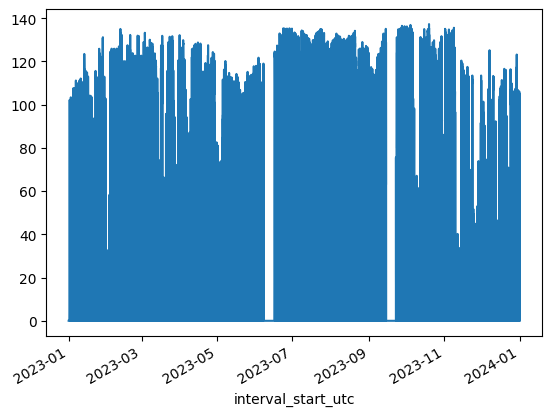

In [30]:
import matplotlib.pyplot as plt

df['telemetered_net_output'].plot()
plt.show()

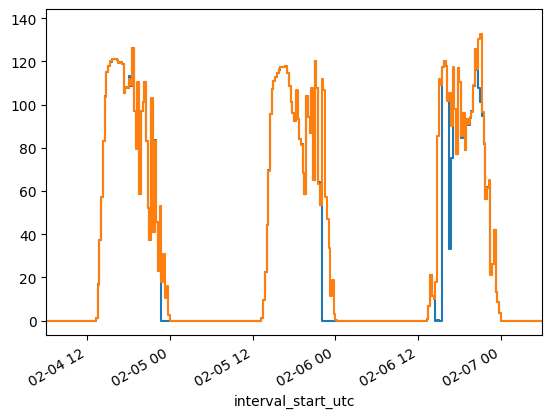

In [31]:
df['telemetered_net_output'].plot(drawstyle='steps-pre')
df['hsl'].plot(drawstyle='steps-pre')
# (df['hsl'] - df['telemetered_net_output']).plot(drawstyle='steps-pre')
plt.xlim(['2023-2-4 6:00','2023-2-7 6:00'])
plt.show()

Get data for the remaining plants:

In [33]:
# merged_df = pd.concat([merged_df_coastal,merged_df_south,merged_df_north,merged_df_panhandle,merged_df_west],axis=0)
merged_df = pd.concat([merged_df_north,merged_df_panhandle,merged_df_west],axis=0)
start_datetime="2023-01-01T00:00"
end_datetime="2024-01-01T00:00"

export_specs_and_timeseries(merged_df,start_datetime,end_datetime,api_key,
                            output_spec_folder="output_specs",
                            output_timeseries_folder='output_timeseries')


Processing: CONIGLIO SOLAR
✅ Saved specs: CONIGLIO_SOLAR_specs.csv

Processing: IMPACT SOLAR
✅ Saved specs: IMPACT_SOLAR_specs.csv

Processing: KELLAM SOLAR
✅ Saved specs: KELLAM_SOLAR_specs.csv

Processing: LILY SOLAR
✅ Saved specs: LILY_SOLAR_specs.csv

Processing: NOBLE SOLAR U1
✅ Saved specs: NOBLE_SOLAR_U1_specs.csv

Processing: MISAE SOLAR U1
✅ Saved specs: MISAE_SOLAR_U1_specs.csv

Processing: ANSON SOLAR U1
✅ Saved specs: ANSON_SOLAR_U1_specs.csv

Processing: ARAGORN SOLAR
✅ Saved specs: ARAGORN_SOLAR_specs.csv

Processing: AZURE SKY SOLAR U1
✅ Saved specs: AZURE_SKY_SOLAR_U1_specs.csv

Processing: BLUEBELL SOLAR II 1 (CAPRICORN RIDGE 4)
✅ Saved specs: BLUEBELL_SOLAR_II_1_(CAPRICORN_RIDGE_4)_specs.csv

Processing: CASTLE GAP SOLAR
✅ Saved specs: CASTLE_GAP_SOLAR_specs.csv

Processing: GALLOWAY 1 SOLAR
✅ Saved specs: GALLOWAY_1_SOLAR_specs.csv

Processing: GREASEWOOD SOLAR 1
✅ Saved specs: GREASEWOOD_SOLAR_1_specs.csv

Processing: HOLSTEIN SOLAR 1
✅ Saved specs: HOLSTEIN_SOLAR_

In [20]:
merged_df = pd.concat([merged_df_coastal,merged_df_south,merged_df_north,merged_df_panhandle,merged_df_west],axis=0)
# merged_df = pd.concat([merged_df_north,merged_df_panhandle,merged_df_west],axis=0)
start_datetime="2024-01-01T00:00"
end_datetime="2025-05-01T00:00"

export_specs_and_timeseries(merged_df,start_datetime,end_datetime,api_key,
                            output_spec_folder="output_specs",
                            output_timeseries_folder='output_timeseries')


Processing: NEBULA SOLAR (RAYOS DEL SOL) U1
✅ Saved specs: NEBULA_SOLAR_(RAYOS_DEL_SOL)_U1_specs.csv
Fetching Page 1...Done in 32.06 seconds. 

Total number of rows: 41013
✅ Saved timeseries: NEBULA_SOLAR_(RAYOS_DEL_SOL)_U1_actual_power_20240101-20250501.csv

Processing: WAGYU SOLAR
✅ Saved specs: WAGYU_SOLAR_specs.csv
Fetching Page 1...Done in 27.2 seconds. 

Total number of rows: 41013
✅ Saved timeseries: WAGYU_SOLAR_actual_power_20240101-20250501.csv

Processing: EAST BLACKLAND SOLAR (PFLUGERVILLE SOLAR)
✅ Saved specs: EAST_BLACKLAND_SOLAR_(PFLUGERVILLE_SOLAR)_specs.csv
Fetching Page 1...Done in 28.71 seconds. 

Total number of rows: 41013
✅ Saved timeseries: EAST_BLACKLAND_SOLAR_(PFLUGERVILLE_SOLAR)_actual_power_20240101-20250501.csv

Processing: ELARA SOLAR
✅ Saved specs: ELARA_SOLAR_specs.csv
Fetching Page 1...Done in 19.43 seconds. 

Total number of rows: 41013
✅ Saved timeseries: ELARA_SOLAR_actual_power_20240101-20250501.csv

Processing: OCI ALAMO 1 SOLAR
✅ Saved specs: OCI_A

In [ ]:
merged_df = pd.concat([merged_df_coastal,merged_df_south,merged_df_north,merged_df_panhandle,merged_df_west],axis=0)
start_datetime="2015-01-01T00:00"
end_datetime="2025-05-01T00:00"

export_specs_and_timeseries(merged_df,start_datetime,end_datetime,api_key,
                            output_spec_folder="output_specs",
                            output_timeseries_folder='output_timeseries')